### Imports

In [2]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peakutils
import os, glob
import data_tools as dt

In [3]:
%load_ext autoreload
%autoreload 2

### Directories

In [4]:
data_dir = os.path.join('./raw_data')
analysis_dir = os.path.join('./analysis')
fig_dir = os.path.join('./figures')

### Constants

Determined in `characterize_dot.ipynb`

In [6]:
MU_B = 5.7883818012e-5 # eV/T
K_B = 8.6173303e-5 # eV/K

ALPHA1_CLSD = 0.0469
ALPHA1_OPN = 0.0295
G1_OPN = 0.417
ALPHA2_CLSD = 0.0442
ALPHA2_OPN = 0.0333
G2_OPN = 0.400
ALPHA3_CLSD = 0.0415
ALPHA3_CLSD = 0.0265

# Calibrate Heater

Find conversion between applied power and dT using dataset 944. Here, a DC current ($I^{DC}_{Heat}$) was used to heat the reservoir.

<IPython.core.display.Javascript object>


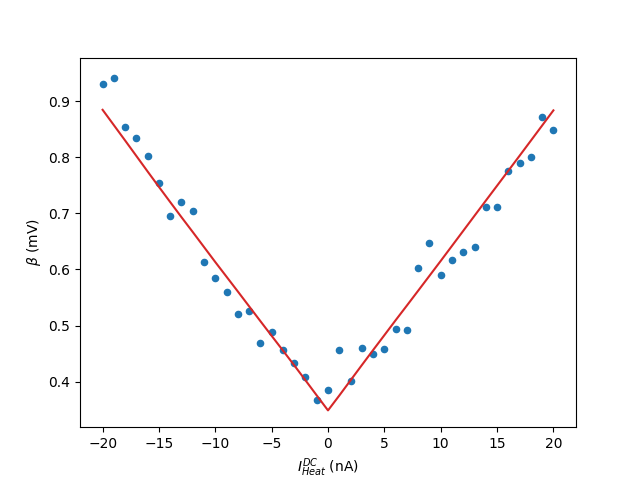

T_{base} (mK) = 94.8
\beta (mV) = 0.1884*\sqrt{P (pW)} + 0.3485


In [36]:
fig, ax = plt.subplots(1,1)

dat = 944
xmult = [0.5, 1e-3*2e-8] # plunger in mV, I_AC in Amps
avgs = 5

### import i_sense ###
swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['i_sense_dc2d'][:], 
                        avgs, axis=1) # rolling mean of sensor data
z = z*1e9 # i_sense (nA)
y = swp['y_array'][:]*xmult[1]*1e9 # I_AC (nA)

### fit i_sense curves ###
span = 5.0
xlim = (-490, -482)
centers = -486*np.ones(len(z))
widths = 0.6*np.ones(len(z))

i_results = dt.i_sense_fit_simultaneous(x, z, centers, widths, xlim, constrain = None, span = span)
i_results['i_heat'] = y

### calculate DC power ###
v = swp['vdc_heat2d'][:].mean(axis=1)
v = v-v[20] # subtract offset voltage
p = (i_results['i_heat'].values*1e-9)*v*1e12 # pW
i_results['p_heat'] = p

### fit beta vs sqrt(power) ###
popt = np.polyfit(np.sqrt(i_results['p_heat']), i_results['beta'], deg=1)
beta_calc = dt.line(np.sqrt(i_results['p_heat']), *popt)
t_calc = ALPHA1_CLSD*beta_calc/(2*K_B)
i_results['T_electron'] = t_calc

ax.scatter(i_results['i_heat'], i_results['beta'], s=20)
ax.plot(i_results['i_heat'], beta_calc, c='C3')
ax.set_xlabel(r'$I^{DC}_{Heat}$ (nA)')
ax.set_ylabel(r'$\beta$ (mV)')

print(r'T_{{base}} (mK) = {0:.1f}'.format(ALPHA1_CLSD*popt[1]/(2*K_B)))
print(r'\beta (mV) = {0:.4f}*\sqrt{{P (pW)}} + {1:.4f}'.format(*popt))

i_results.to_csv(os.path.join(analysis_dir,'dat944_i_results.csv'), index=False) # save

In [37]:
def power_to_beta(power):
    return 0.1884*np.sqrt(power) + 0.3485

# Fit 0-1 peak data

Fit dI curves to find dS at the 0-1 electron transition.

<IPython.core.display.Javascript object>


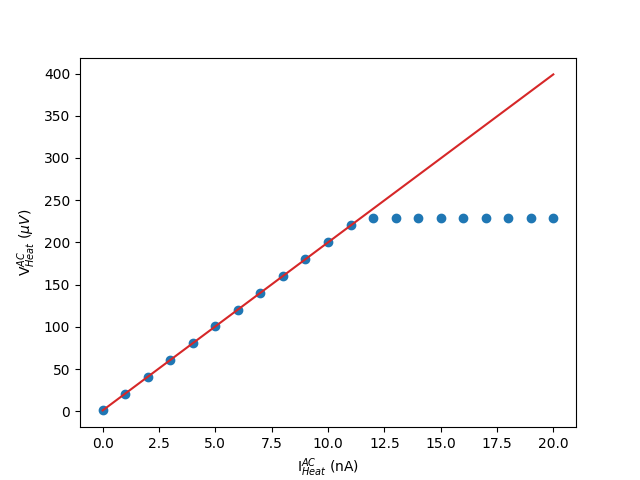

In [42]:
# calculate applied AC power
# lock in measuring v_heat overloaded, so I need to clean up the data
dat = 945
xmult = [0.5, 2e-8] # plunger in mV, I_ac in Amps

swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
v = swp['vac_heat2d'][:].mean(axis=1)*1e6
y = swp['y_array'][:]*xmult[1]*1e9

fig, ax = plt.subplots(1,1)

ax.scatter(y, v)
ax.set_xlabel('I$^{AC}_{Heat}$ (nA)')
ax.set_ylabel('V$^{AC}_{Heat}$ ($\mu V$)')

popt = np.polyfit(y[:12], v[:12], deg=1)
v_corrected = dt.line(y, *popt)
ax.plot(y, v_corrected, c='C3')

p = v_corrected*y*1e-3
t_calc = ALPHA1_CLSD*power_to_beta(p)/(2*K_B)

di_results = pd.DataFrame({'i_heat':y, 'v_heat':v_corrected, 'p_heat':p, 't_calc':t_calc, 'dT':t_calc-t_calc[0]})

In [48]:
# fit this dataset twice
#    first with delta=0, second with delta as a free parameter

avgs = 5
span = 5.0

x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g5x2d'][:], avgs, axis=1)
z = z*(1e-8)*(1e9)  # convert from dV to dI (nA)

xlim = (-490, -486)
centers = -488*np.ones(len(z))
widths = 0.6*np.ones(len(z))

di_zero_params = dt.di_fit_simultaneous(x, z, centers, widths, xlim, constrain = None, span = span, fix=['delta'])
di_free_params = dt.di_fit_simultaneous(x, z, centers, widths, xlim, constrain = None, span = span)

pd.concat([di_results, di_zero_params], axis=1).to_csv(
    os.path.join(analysis_dir,'dat945_di_zero_fits.csv'), index=False)
pd.concat([di_results, di_free_params], axis=1).to_csv(
    os.path.join(analysis_dir,'dat945_di_free_fits.csv'), index=False)